In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
df_train = pd.read_csv('train bio.csv')
df_test = pd.read_csv('test bio.csv')

In [3]:
X_train, y_train = df_train.drop(columns=['accuracy']), df_train['accuracy']
X_test, y_test = df_test.drop(columns=['accuracy']), df_test['accuracy']

### 1.1) Try Logistic Regression with all features (full set of categorical features)

In [21]:
# helper function to get cross-validation results
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix

def show_cv_results(model, x, y, cv=10):
    scores = cross_validate(model, x, y, cv=cv, return_train_score=True)
    print("Mean test score:", scores["test_score"].mean()) # mean test accuracy score
    display(pd.DataFrame(scores))

In [22]:
lr = LogisticRegression(max_iter=10000, solver="liblinear")

show_cv_results(lr, X_train, y_train)

Mean test score: 0.62057761732852


,fit_time,score_time,test_score,train_score
0,0.202284,0.026176,0.635379,0.850782
1,0.186300,0.021846,0.624549,0.839150
2,0.195785,0.022361,0.602888,0.842359
3,0.183881,0.022620,0.628159,0.842359
4,0.187986,0.022642,0.620939,0.827918
5,0.192754,0.021889,0.628159,0.848375
6,0.186519,0.022642,0.566787,0.847172
7,0.183712,0.021998,0.620939,0.846771
8,0.181628,0.022859,0.624549,0.843562
9,0.181096,0.022644,0.653430,0.848777


In [23]:
show_cv_results(lr, X_test, y_test)

Mean test score: 0.6271400085457912


,fit_time,score_time,test_score,train_score
0,0.083359,0.020133,0.588235,0.870907
1,0.079798,0.021474,0.663866,0.873714
2,0.078885,0.021390,0.571429,0.871843
3,0.077098,0.021060,0.638655,0.866230
4,0.078929,0.022910,0.647059,0.872778
5,0.084228,0.021132,0.605042,0.871843
6,0.079092,0.020775,0.638655,0.869036
7,0.081615,0.020817,0.621849,0.876520
8,0.082929,0.020647,0.644068,0.871963
9,0.079044,0.020788,0.652542,0.879439


In [24]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import make_pipeline

k = 35 # 35 is lowest we can go to get 62% test acc

model_with_selection = make_pipeline(
    SelectKBest(score_func=chi2, k=k),
    LogisticRegression(max_iter=10000, solver="liblinear")
)

model_with_selection.fit(X_train, y_train)


Pipeline(steps=[('selectkbest',
                 SelectKBest(k=35, score_func=<function chi2 at 0x1602b93a0>)),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, solver='liblinear'))])

In [25]:
# Performance on the test set

def score_model(model, x, y):
    pred = model.predict(x)
    print(classification_report(y, pred))

    cm = confusion_matrix(y, pred)
    columns = np.unique(y)
    df_cm = pd.DataFrame(cm, index=columns, columns=columns)
    ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

              precision    recall  f1-score   support

           0       0.66      0.83      0.74       739
           1       0.52      0.29      0.38       449

    accuracy                           0.63      1188
   macro avg       0.59      0.56      0.56      1188
weighted avg       0.61      0.63      0.60      1188



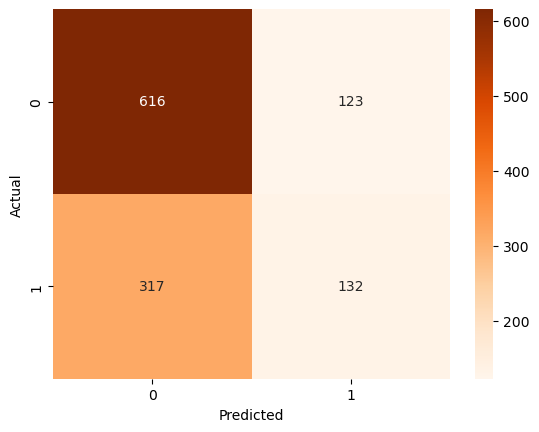

In [26]:
score_model(model_with_selection, X_test, y_test)

### 1.2) Hyperparameter Tuning for Logistic Regression

In [27]:
# https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# parameter grid
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
#     'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
lr = LogisticRegression(max_iter=10000, solver='liblinear')
clf = GridSearchCV(lr,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=10000, solver='liblinear'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [28]:
# helper function to view grid search results

def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")

In [29]:
report_GridSearchCV_results(clf)

Best combination of hyperparams:
 {'C': 0.1, 'penalty': 'l2'} 

Best mean_test_score score:
 0.6379061371841155 

Score by fold for best estimator:
 [0.6967509025270758, 0.628158844765343, 0.628158844765343, 0.6353790613718412, 0.6462093862815884, 0.628158844765343, 0.6064981949458483, 0.631768953068592, 0.628158844765343, 0.6498194945848376] 



              precision    recall  f1-score   support

           0       0.67      0.86      0.75       739
           1       0.57      0.30      0.40       449

    accuracy                           0.65      1188
   macro avg       0.62      0.58      0.58      1188
weighted avg       0.63      0.65      0.62      1188



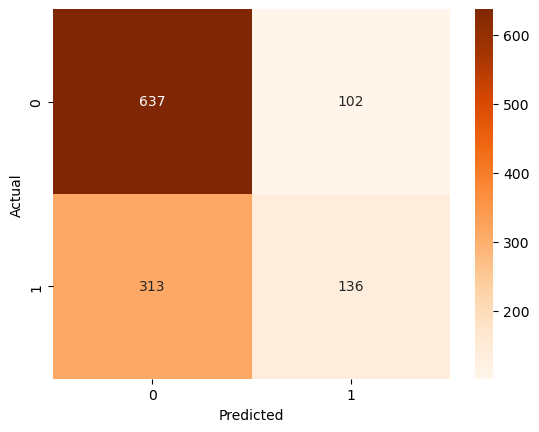

In [30]:
score_model(clf, X_test, y_test)

### 2.1) RandomForest Baseline Model with all features

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

clf = RandomForestClassifier(random_state=42, n_estimators=100)
clf.fit(X_train, y_train)
        
y_train_pred = clf.predict(X_train)
print('Training Accuracy: ', metrics.accuracy_score(y_train, y_train_pred))
print(classification_report(y_train,y_train_pred))
print(confusion_matrix(y_train,y_train_pred))
print()
y_test_pred = clf.predict(X_test)
print('Test Accuracy: ', metrics.accuracy_score(y_test, y_test_pred))
print(classification_report(y_test,y_test_pred))
print(confusion_matrix(y_test,y_test_pred))

Training Accuracy:  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1723
           1       1.00      1.00      1.00      1047

    accuracy                           1.00      2770
   macro avg       1.00      1.00      1.00      2770
weighted avg       1.00      1.00      1.00      2770

[[1723    0]
 [   0 1047]]

Test Accuracy:  0.6430976430976431
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       739
           1       0.59      0.19      0.29       449

    accuracy                           0.64      1188
   macro avg       0.62      0.55      0.52      1188
weighted avg       0.63      0.64      0.58      1188

[[679  60]
 [364  85]]


### 2.2) Hyperparameter tuning for RandomForest

#### RandomizedSearchCV

In [41]:
# randomised search

from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

distributions = {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
#  'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 6],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600]}
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = distributions, cv = 3, n_jobs = 2)
rf_random.fit(X_train, y_train)

report_GridSearchCV_results(rf_random)

Best combination of hyperparams:
 {'n_estimators': 1200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 60, 'bootstrap': False} 

Best mean_test_score score:
 0.6252694879455443 

Score by fold for best estimator:
 [0.6287878787878788, 0.6251354279523293, 0.6218851570964247] 



              precision    recall  f1-score   support

           0       0.65      0.94      0.77       739
           1       0.65      0.18      0.28       449

    accuracy                           0.65      1188
   macro avg       0.65      0.56      0.53      1188
weighted avg       0.65      0.65      0.59      1188



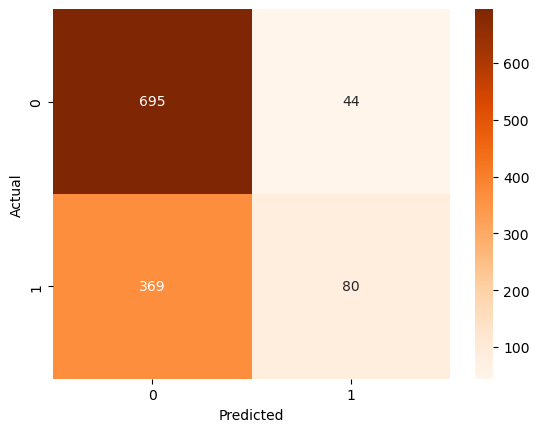

In [43]:
score_model(rf_random, X_test, y_test)

In [44]:
rf = RandomForestClassifier(n_estimators= 1200, min_samples_split=10, min_samples_leaf = 4, max_depth = 60)
rf.fit(X_train,y_train)
sorted_idx = rf.feature_importances_.argsort()
feature_names=X_train.columns

In [46]:
feature_names.__len__()

7213

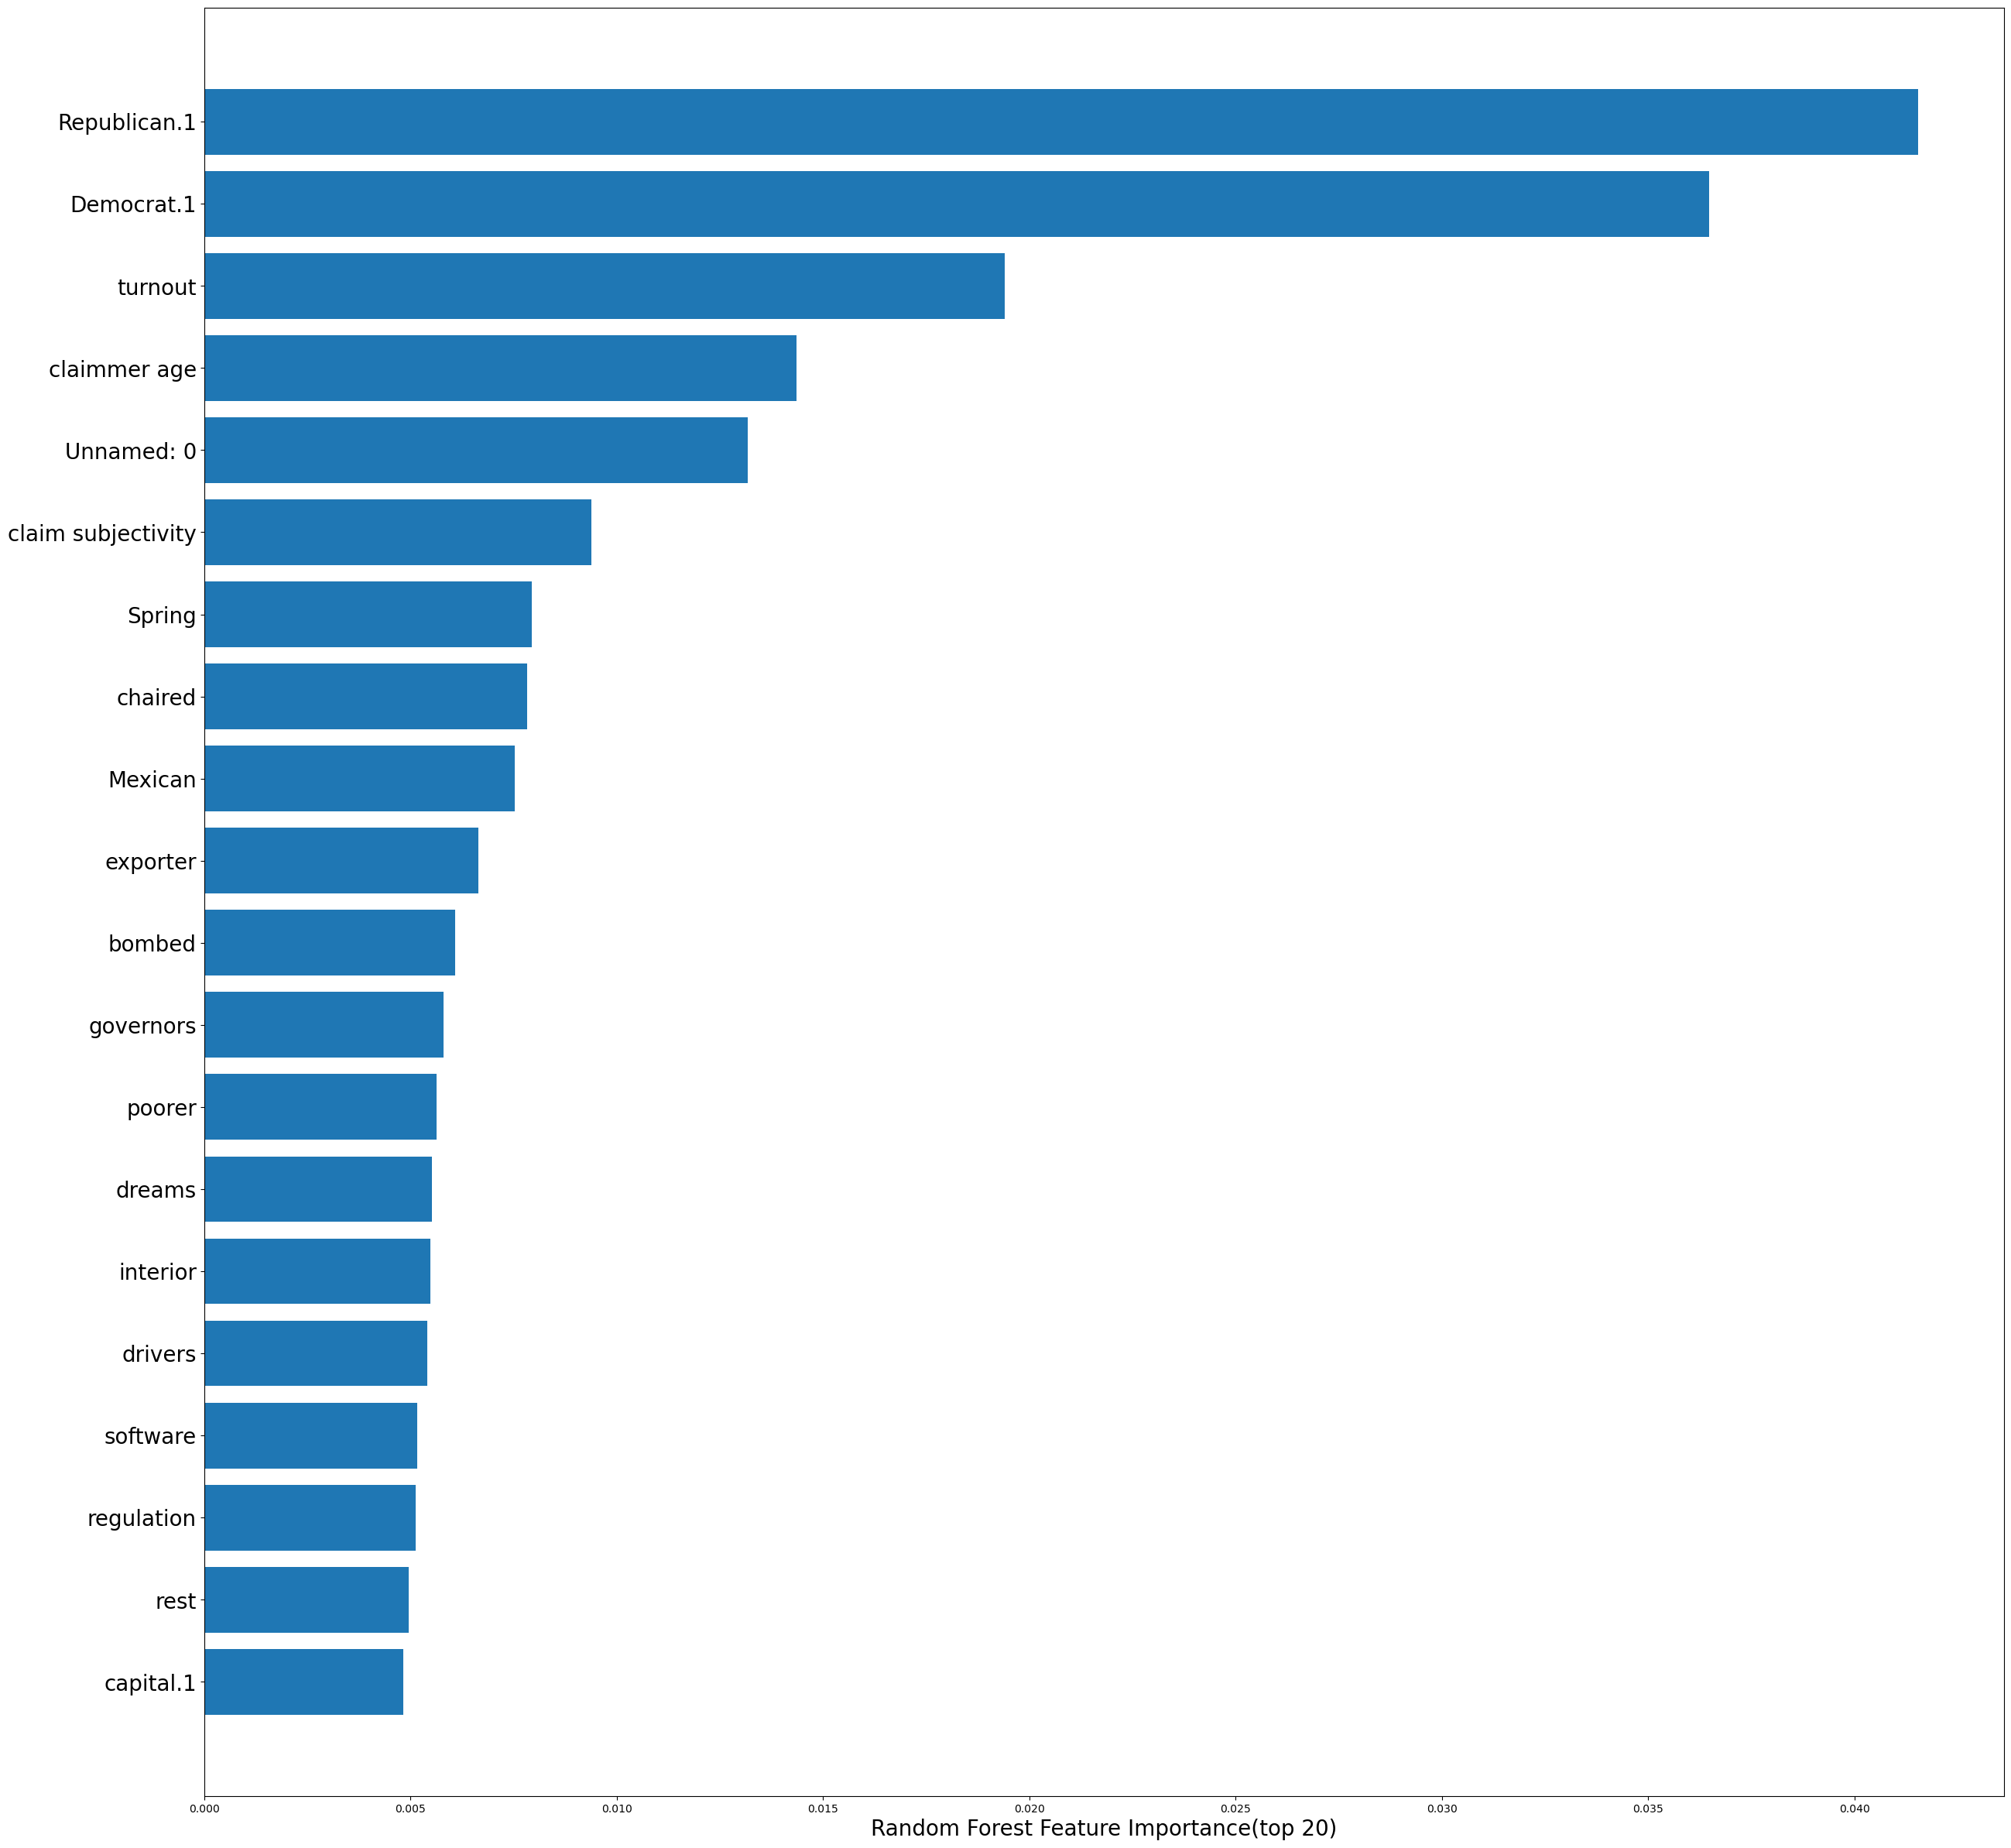

In [51]:
fig, axes = plt.subplots(figsize=(30,30))
plt.barh(feature_names[sorted_idx][feature_names.__len__()-20:],rf.feature_importances_[sorted_idx][feature_names.__len__()-20:])
plt.xlabel("Random Forest Feature Importance(top 20)", fontdict={'size':20})
plt.yticks(font={'size':20})
plt.show()

#### GridSearchCV

In [6]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)
grid_rf = {
    "max_depth": [5, 50, 75, 100],
    'min_samples_split': [12, 16, 20],
    'criterion': ['gini', 'entropy']
}
rf_grid = GridSearchCV(estimator = rf,      # model
                   param_grid = grid_rf,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 50, 75, 100],
                         'min_samples_split': [12, 16, 20]},
             scoring='accuracy')

In [9]:
report_GridSearchCV_results(rf_grid)

Best combination of hyperparams:
 {'criterion': 'gini', 'max_depth': 50, 'min_samples_split': 20} 

Best mean_test_score score:
 0.6231046931407942 

Score by fold for best estimator:
 [0.5992779783393501, 0.6534296028880866, 0.6064981949458483, 0.6173285198555957, 0.6101083032490975, 0.631768953068592, 0.6137184115523465, 0.6425992779783394, 0.628158844765343, 0.628158844765343] 



In [11]:
# performance on test set
rf = RandomForestClassifier(random_state=42,max_depth=50,min_samples_split=20)
rf.fit(X_train, y_train)
score_model(rf,X_test,y_test)

RandomForestClassifier(max_depth=50, min_samples_split=20, random_state=42)

### 3) Gradient Boosting

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators = 300, learning_rate = 0.1,random_state = 42) # max_features=5

gbc.fit(X_train, y_train)

print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

0.8386281588447654
0.6414141414141414


In [35]:
# randomised search for GB

params = {'learning_rate':[0.01,0.05,0.1],
'n_estimators':np.arange(100,500,100)}

search = RandomizedSearchCV(GradientBoostingClassifier(random_state=42), params, random_state=42, cv=3)

gb_rand_search = search.fit(X_train, y_train)
print('Best Hyperparameters: %s' % gb_rand_search.best_params_)
print('Best Score: %s' % gb_rand_search.best_score_)

Best Hyperparameters: {'n_estimators': 400, 'learning_rate': 0.05}
Best Score: 0.6267183520704647
